In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

/kaggle/input/bank-customer-churn-modeling/Churn_Modelling.csv


In [2]:
df=pd.read_csv('/kaggle/input/bank-customer-churn-modeling/Churn_Modelling.csv')
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Removing those columns which are not helpful in predictions

In [3]:
df.drop(['RowNumber','CustomerId','Surname'],axis='columns',inplace=True)

In [4]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.shape

(10000, 11)

In [6]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

## PreProcessing the dataset

In [7]:
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [8]:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [9]:
df['Tenure'].unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0])

In [10]:
df['NumOfProducts'].unique()

array([1, 3, 2, 4])

In [11]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [12]:
df=pd.get_dummies(df,columns=['Gender','Geography'],drop_first=True)

In [13]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
cols=['CreditScore','Age','Balance','EstimatedSalary']
df[cols]=scaler.fit_transform(df[cols])

In [15]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,0.538,0.324324,2,0.000000,1,1,1,0.506735,1,0,0,0
1,0.516,0.310811,1,0.334031,1,0,1,0.562709,0,0,0,1
2,0.304,0.324324,8,0.636357,3,1,0,0.569654,1,0,0,0
3,0.698,0.283784,1,0.000000,2,0,0,0.469120,0,0,0,0
4,1.000,0.337838,2,0.500246,1,1,1,0.395400,0,0,0,1


### Since we see here that our dataset is imbalanced so we have to do sampling using SMOTE

In [16]:
x=df[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard','IsActiveMember', 'EstimatedSalary', 'Gender_Male','Geography_Germany', 'Geography_Spain']]
y=df['Exited']

In [17]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy='minority')
x_sm,y_sm=smote.fit_resample(x,y)

In [18]:
y_sm.value_counts()

0    7963
1    7963
Name: Exited, dtype: int64

## Neural Network Model Training

In [19]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_sm,y_sm,test_size=0.3,random_state=0,stratify=y_sm)

In [20]:
x_train.shape

(11148, 11)

In [21]:
y_train.value_counts()

0    5574
1    5574
Name: Exited, dtype: int64

In [22]:
model = keras.Sequential([
    keras.layers.Dense(60, input_dim=x_train.shape[1], activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=100, batch_size=8)

Epoch 1/100
1394/1394 [==============================] - 3s 1ms/step - loss: 0.7527 - accuracy: 0.5014
Epoch 2/100
1394/1394 [==============================] - 2s 1ms/step - loss: 0.6835 - accuracy: 0.5620
Epoch 3/100
1394/1394 [==============================] - 2s 1ms/step - loss: 0.6464 - accuracy: 0.6287
Epoch 4/100
1394/1394 [==============================] - 2s 1ms/step - loss: 0.6230 - accuracy: 0.6767
Epoch 5/100
1394/1394 [==============================] - 2s 1ms/step - loss: 0.5926 - accuracy: 0.7013
Epoch 6/100
1394/1394 [==============================] - 2s 1ms/step - loss: 0.5789 - accuracy: 0.7185
Epoch 7/100
1394/1394 [==============================] - 2s 1ms/step - loss: 0.5575 - accuracy: 0.7334
Epoch 8/100
1394/1394 [==============================] - 2s 1ms/step - loss: 0.5463 - accuracy: 0.7394
Epoch 9/100
1394/1394 [==============================] - 2s 1ms/step - loss: 0.5395 - accuracy: 0.7349
Epoch 10/100
1394/1394 [==============================] - 2s 1ms/step - l

In [23]:
model.evaluate(x_test,y_test)

150/150 [==============================] - 0s 864us/step - loss: 0.4237 - accuracy: 0.7941


[0.42366161942481995, 0.7940561175346375]

## Predictions

In [24]:
yp=model.predict(x_test)

In [25]:
yp[:5]

array([[0.5572149 ],
       [0.25473005],
       [0.46378347],
       [0.44505835],
       [0.2265594 ]], dtype=float32)

In [26]:
y_pred=[]
for i in yp:
    if i>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [27]:
y_pred[:5]

[1, 0, 0, 0, 0]

In [28]:
y_test[:5]

13122    1
7572     0
15270    1
15179    1
1337     0
Name: Exited, dtype: int64

### Visualizing Predictions

Text(33.0, 0.5, 'Truth')

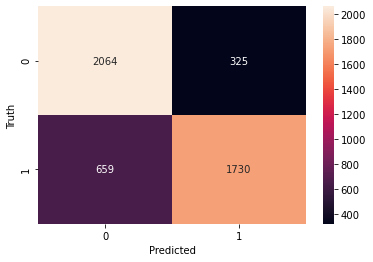

In [29]:
import seaborn as sns
cm=tf.math.confusion_matrix(labels=y_test,predictions=y_pred)
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81      2389
           1       0.84      0.72      0.78      2389

    accuracy                           0.79      4778
   macro avg       0.80      0.79      0.79      4778
weighted avg       0.80      0.79      0.79      4778

